# Task -2: Classifying Text into Counter and Non Counter Class using cross community predictions
### This notebook is used to measure the performance of using two community for training and one community for testing  out of the three communities.

In [18]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from collections import Counter
from string import punctuation
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
from sklearn import ensemble
from sklearn import neural_network
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
import pickle
from nltk.stem.porter import *
ps = PorterStemmer()
from scipy.sparse import vstack, hstack
import sys
sys.path.insert(0, '../../')
####features module has the necessary function for feature generation 
from utils.features import *
###tokenize module has the tokenization funciton
from utils.tokenize import *
###helper prints confusion  matrix and stores results
from utils.helper import *
###common preprocessing imports
from utils.commen_preprocess import *

####gensim load 
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import os
import numpy as np

import joblib

####ipywidgets 

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#### Word_to_vec model  loading 
1. change the path of glove model file

In [2]:
GLOVE_MODEL_FILE="../../../embeddings/glove.840B.300d.txt"
print(os.path.isfile(GLOVE_MODEL_FILE))

## change the embedding dimension according to the model
EMBEDDING_DIM = 300
def loadGloveModel2(glove_file):
    tmp_file = get_tmpfile("test_crawl_200.txt")

    # call glove2word2vec script
    # default way (through CLI): python -m gensim.scripts.glove2word2vec --input <glove_file> --output <w2v_file>

    glove2word2vec(glove_file, tmp_file)
    model=KeyedVectors.load_word2vec_format(tmp_file)
    return model

word2vec_model = loadGloveModel2(GLOVE_MODEL_FILE)#saving the classification report

True


## Dataset is loaded here

In [3]:
### change the path where the data is kept
path='../../Data/Counterspeech_Dataset.json'
with open(path) as fp:
    train_data = json.load(fp)

In [4]:
def convert_class_label(input_text):
    if input_text:
        return 'counter'
    else:
        return 'noncounter'

In [5]:
pd_train = pd.DataFrame(columns=['id','class','community','category','text'])

for count, each in enumerate(train_data):
    try:
        pd_train.loc[count]  = [each['id'], convert_class_label(each['CounterSpeech']), each['Community'],each['Category'],each['commentText']]
    except:
        pass
print('Training Data Loading Completed...')

Training Data Loading Completed...


In [6]:
pd_train['text'].replace('', np.nan, inplace=True)
pd_train.dropna(subset=['text'], inplace=True)
pd_train.head()

id       class community category  \
0  Ugw-_mfnTo9SUniGGTN4AaABAg  noncounter      jews  Default   
1        UgiMOgO3u4akkngCoAEC  noncounter      lgbt  Default   
2  UgzemCMbg-ri1ri7sCt4AaABAg     counter      jews      2,8   
3        UghFhzrURF1svHgCoAEC     counter      jews        8   
4  Ugzr50sQdH0Ictuex214AaABAg     counter      jews        8   

                                                text  
0  she is one of the last brave white women with ...  
1                                AMEN PASTOR!!!!!!!!  
2  What kind of God is it that Hates people & Cur...  
3  Question - Which comment is racist and why?\n ...  
4  That Israel fail that is nothing new. That Isr...

In [7]:
#### converting the data into text and labels dictionary

def get_data(pd_train):
    comments=pd_train['text'].values
    labels=pd_train['class'].values
    list_comment=[]
    for comment,label in zip(comments,labels):
        temp={}
        temp['text']=comment
        temp['label']=label
        list_comment.append(temp)
    return list_comment    

In [8]:
###division of training set into three parts corresponding to various community 
part_j=pd_train.loc[pd_train['community']=='jews']
part_b=pd_train.loc[pd_train['community']=='black']
part_l=pd_train.loc[pd_train['community']=='lgbt']



## Model selection and feature selection 

In [9]:
def get_model(m_type=None):
    if not m_type:
        print("ERROR: Please specify a model type!")
        return None
    if m_type == 'decision_tree_classifier':
        logreg = tree.DecisionTreeClassifier(class_weight='balanced')
    elif m_type == 'MLPClassifier':
        logreg = neural_network.MLPClassifier((500))
    elif m_type == 'KNeighborsClassifier':
        logreg = neighbors.KNeighborsClassifier(n_neighbors = 10)
    elif m_type == 'ExtraTreeClassifier':
        logreg = tree.ExtraTreeClassifier()
    elif m_type == 'ExtraTreeClassifier_2':
        logreg = ensemble.ExtraTreesClassifier()
    elif m_type == 'RandomForestClassifier':
        logreg = ensemble.RandomForestClassifier(class_weight='balanced')
    elif m_type == 'Logistic_Regression':
        logreg = linear_model.LogisticRegression(class_weight='balanced')
    elif m_type == 'SVC':
        logreg = SVC(class_weight='balanced');
    elif m_type == 'Catboost':
        logreg = CatBoostClassifier(iterations=100,scale_pos_weight=(4048/5335))
    elif m_type == 'XGB_classifier':
        logreg=XGBClassifier(scale_pos_weight=(4048/5335),n_estimators=500,nthread=12)
    elif m_type == 'Gaussian_NB':
        logreg = GaussianNB()
    else:
        print("give correct model")
        
    return logreg

def get_feature(pd_train,f_type=None):
    if not f_type:
        print("ERROR: Please specify a model type!")
        return None,None
    if f_type == 'google_not_preprocess':
        X,y=gen_data_google2(pd_train)
    elif f_type == 'word_to_vec_embed':
        X,y=gen_data_embed(pd_train,word2vec_model)
    elif f_type == 'google_preprocess':
        X,y=gen_data_google(pd_train)
    elif f_type == 'tfidf_not_preprocess':
        X,y=gen_data_new_tfidf2(pd_train)
    elif f_type == 'tfidf_preprocess':
        X,y=gen_data_new_tfidf(pd_train)
    elif f_type == 'google_preprocess_tfidf_preprocess':
        X,y=combine_tf_google_rem(pd_train)
    elif f_type == 'google_nopreprocess_tfidf_nopreprocess':
        X,y=combine_tf_google_norem(pd_train)
    elif f_type == 'google_preprocess_tfidf_nopreprocess':
        X,y=combine_tf_norem_google_rem(pd_train)
    elif f_type == 'google_nopreprocess_tfidf_preprocess':
        X,y=combine_tf_rem_google_norimportem(pd_train)
    elif f_type == 'google_preprocess_embed':
        X,y=combine_google_rem_embed(pd_train,word2vec_model)
    elif f_type == 'tfidf_preprocess_embed':
        X,y=combine_tf_rem_embed(pd_train,word2vec_model)
    elif f_type == 'google_preprocess_tfidf_preprocess_embed':
        ###best features####
        X,y=combine_tf_rem_google_rem_embed(pd_train,word2vec_model)
    else:
        print("give correct feature selection")    
    return X,y

In [10]:
import jsave_model=Trueson
with open('binary_all_parameters.json') as f:
        parameters=json.load(f)

In [20]:
def classification(classifier_model,feature_model,train,test,confusion_name,report_name,pred_name_save,test_on,save_model=False):
    ###select data use individually for test and train methods described at the top
    X_train,y_train=get_feature(train,f_type=feature_model)
    X_test,y_test=get_feature(test,f_type=feature_model)
    classifier=get_model(classifier_model)
    try:
        model_parameter=parameters[classifier_model+'+'+feature_model]
        for k,v in param_set.items():
            setattr(model_parameter,k,v)
    except:
        pass
      
    
    Classifier_Train_X = np.array(X_train, copy=False)
    Classifier_Train_Y = y_train
    Classifier_Test_X = np.array(X_test, copy=False)
    Classifier_Test_Y = y_test
    
    label_map = {
                'counter': 0,
                'noncounter': 1
            }
    temp=[]
    for data in Classifier_Train_Y:
            temp.append(label_map[data])

    Classifier_Train_Y=np.array(temp)


    temp=[]
    for data in Classifier_Test_Y:
            temp.append(label_map[data])

    Classifier_Test_Y=np.array(temp)
    classifier.fit(Classifier_Train_X,Classifier_Train_Y)
    if(save_model==True):
        filename = '../../Best_model/'+test_on+'_'+classifier_model+'_task_2.joblib.pkl'
        joblib.dump(classifier, filename, compress=9)
    
    y_pred = classifier.predict(Classifier_Test_X)
    y_pred_train = classifier.predict(Classifier_Train_X)
    print('accuracy_train:',accuracy_score(Classifier_Train_Y, y_pred_train),'accuracy_test:',accuracy_score(Classifier_Test_Y, y_pred))
    report = classification_report(Classifier_Train_Y , y_pred_train )
    print(report)
    report = classification_report(Classifier_Test_Y , y_pred )
    cm=confusion_matrix(Classifier_Test_Y, y_pred)
    plt=plot_confusion_matrix(cm,normalize= True,target_names = ['counter','non_counter'],title = "Confusion Matrix")
    plt.savefig(confusion_name)
    print(report)
    df_result=pandas_classification_report(Classifier_Test_Y,y_pred)
    df_result.to_csv(report_name,  sep=',')
    with open(pred_name_save, 'wb') as f:
            pickle.dump([Classifier_Test_Y,y_pred], f)


## Models available
1. decision_tree_classifier
2. MLPClassifier
3. KNeighborsClassifier
4. ExtraTreeClassifier
5. ExtraTreeClassifier_2
6. RandomForestClassifier
7. SVC
8. Catboost
9. XGB_classifier
10. Logistic Regression
11. Gaussian Naive bayes

## Feature Models available
1. google_not_preprocess
2. word_to_vec_embed
3. google_preprocess
4. tfidf_not_preprocess
5. tfidf_preprocess
6. google_preprocess_tfidf_preprocess
7. google_nopreprocess_tfidf_nopreprocess
8. google_preprocess_tfidf_nopreprocess
9. google_nopreprocess_tfidf_preprocess
10. google_preprocess_embed
11. tfidf_preprocess_embed
12. google_preprocess_tfidf_preprocess_embed


## all_classification_task

#### PART 1 train on jew and lgbt test on black

In [12]:
train = pd.concat([part_j,part_l])
test =  part_b

options_ft=['google_not_preprocess','word_to_vec_embed','google_preprocess','tfidf_not_preprocess','tfidf_preprocess','google_preprocess_tfidf_preprocess','google_nopreprocess_tfidf_nopreprocess','google_preprocess_tfidf_nopreprocess', 'google_nopreprocess_tfidf_preprocess','google_preprocess_embed','tfidf_preprocess_embed','google_preprocess_tfidf_preprocess_embed']
ft= widgets.Dropdown(options=options_ft, value=None)
print('select feature combination') 
ft


select feature combination


Dropdown(options=('google_not_preprocess', 'word_to_vec_embed', 'google_preprocess', 'tfidf_not_preprocess', 'tfidf_preprocess', 'google_preprocess_tfidf_preprocess', 'google_nopreprocess_tfidf_nopreprocess', 'google_preprocess_tfidf_nopreprocess', 'google_nopreprocess_tfidf_preprocess', 'google_preprocess_embed', 'tfidf_preprocess_embed', 'google_preprocess_tfidf_preprocess_embed'), value=None)

In [13]:
options_clf=['decision_tree_classifier','MLPClassifier','KNeighborsClassifier','ExtraTreeClassifier','ExtraTreeClassifier_2','RandomForestClassifier','SVC','Catboost','XGB_classifier','Logistic_Regression','Gaussian Naive bayes']
clf= widgets.Dropdown(options=options_clf, value=None)
print('select a model') 
clf

select a model


Dropdown(options=('decision_tree_classifier', 'MLPClassifier', 'KNeighborsClassifier', 'ExtraTreeClassifier', 'ExtraTreeClassifier_2', 'RandomForestClassifier', 'SVC', 'Catboost', 'XGB_classifier', 'Logistic_Regression', 'Gaussian Naive bayes'), value=None)

ending


/home/binny/anaconda3/envs/punyajoy-nogpu/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fifti'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


ending


/home/binny/anaconda3/envs/punyajoy-nogpu/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy_train: 0.8002683732452519 accuracy_test: 0.6046291922531885
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      4667
           1       0.81      0.80      0.81      5021

   micro avg       0.80      0.80      0.80      9688
   macro avg       0.80      0.80      0.80      9688
weighted avg       0.80      0.80      0.80      9688

              precision    recall  f1-score   support

           0       0.62      0.67      0.64      2231
           1       0.59      0.54      0.56      2003

   micro avg       0.60      0.60      0.60      4234
   macro avg       0.60      0.60      0.60      4234
weighted avg       0.60      0.60      0.60      4234

complete one


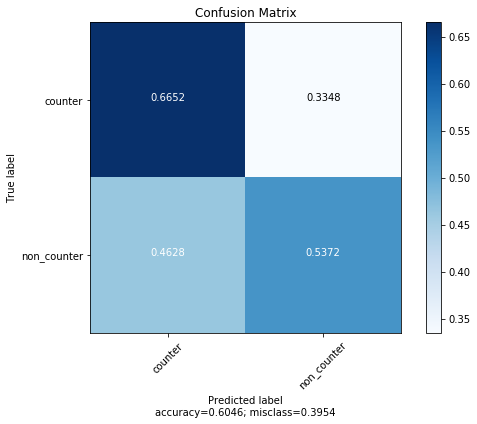

In [21]:
im='black_'+clf.value+ft.value+'_cm.png'
###report_name###
re='black_'+clf.value+ft.value+'_report.csv'

classification(classifier_model=clf.value,feature_model=ft.value,train=train,test=test,confusion_name=im,report_name=re,pred_name_save='black_all_save.pkl',test_on='black',save_model=True)
print("complete one")

#### PART 2 train on black and jew data test on lgbt data

In [22]:
train = pd.concat([part_j,part_b])
test =  part_l

options_ft=['google_not_preprocess','word_to_vec_embed','google_preprocess','tfidf_not_preprocess','tfidf_preprocess','google_preprocess_tfidf_preprocess','google_nopreprocess_tfidf_nopreprocess','google_preprocess_tfidf_nopreprocess', 'google_nopreprocess_tfidf_preprocess','google_preprocess_embed','tfidf_preprocess_embed','google_preprocess_tfidf_preprocess_embed']
ft= widgets.Dropdown(options=options_ft, value=None)
print('select feature combination') 
ft

select feature combination


Dropdown(options=('google_not_preprocess', 'word_to_vec_embed', 'google_preprocess', 'tfidf_not_preprocess', 'tfidf_preprocess', 'google_preprocess_tfidf_preprocess', 'google_nopreprocess_tfidf_nopreprocess', 'google_preprocess_tfidf_nopreprocess', 'google_nopreprocess_tfidf_preprocess', 'google_preprocess_embed', 'tfidf_preprocess_embed', 'google_preprocess_tfidf_preprocess_embed'), value=None)

In [23]:
options_clf=['decision_tree_classifier','MLPClassifier','KNeighborsClassifier','ExtraTreeClassifier','ExtraTreeClassifier_2','RandomForestClassifier','SVC','Catboost','XGB_classifier','Logistic_Regression','Gaussian Naive bayes']
clf= widgets.Dropdown(options=options_clf, value=None)
print('select a model') 
clf

select a model


Dropdown(options=('decision_tree_classifier', 'MLPClassifier', 'KNeighborsClassifier', 'ExtraTreeClassifier', 'ExtraTreeClassifier_2', 'RandomForestClassifier', 'SVC', 'Catboost', 'XGB_classifier', 'Logistic_Regression', 'Gaussian Naive bayes'), value=None)

ending


/home/binny/anaconda3/envs/punyajoy-nogpu/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fifti'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


ending


/home/binny/anaconda3/envs/punyajoy-nogpu/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy_train: 0.7858460870509063 accuracy_test: 0.6145678488001699
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      4150
           1       0.82      0.79      0.80      5063

   micro avg       0.79      0.79      0.79      9213
   macro avg       0.78      0.79      0.78      9213
weighted avg       0.79      0.79      0.79      9213

              precision    recall  f1-score   support

           0       0.70      0.60      0.64      2748
           1       0.53      0.64      0.58      1961

   micro avg       0.61      0.61      0.61      4709
   macro avg       0.61      0.62      0.61      4709
weighted avg       0.63      0.61      0.62      4709

complete two


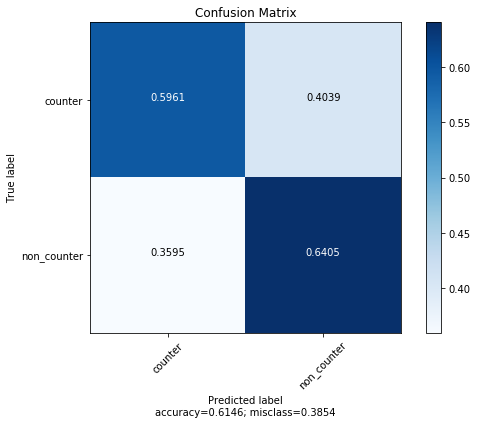

In [24]:
im='lgbt_'+clf.value+ft.value+'_cm.png'
###report_name###
re='lgbt_'+clf.value+ft.value+'_report.csv'

classification(classifier_model=clf.value,feature_model=ft.value,train=train,test=test,confusion_name=im,report_name=re,pred_name_save='lgbt_all_save.pkl',test_on='lgbt',save_model=True)

print("complete two")

#### PART 3 train on black and lgbt data test on jew data

In [25]:
train = pd.concat([part_b,part_l])
test =  part_j

options_ft=['google_not_preprocess','word_to_vec_embed','google_preprocess','tfidf_not_preprocess','tfidf_preprocess','google_preprocess_tfidf_preprocess','google_nopreprocess_tfidf_nopreprocess','google_preprocess_tfidf_nopreprocess', 'google_nopreprocess_tfidf_preprocess','google_preprocess_embed','tfidf_preprocess_embed','google_preprocess_tfidf_preprocess_embed']
ft= widgets.Dropdown(options=options_ft, value=None)
print('select feature combination') 
ft

select feature combination


Dropdown(options=('google_not_preprocess', 'word_to_vec_embed', 'google_preprocess', 'tfidf_not_preprocess', 'tfidf_preprocess', 'google_preprocess_tfidf_preprocess', 'google_nopreprocess_tfidf_nopreprocess', 'google_preprocess_tfidf_nopreprocess', 'google_nopreprocess_tfidf_preprocess', 'google_preprocess_embed', 'tfidf_preprocess_embed', 'google_preprocess_tfidf_preprocess_embed'), value=None)

In [26]:
options_clf=['decision_tree_classifier','MLPClassifier','KNeighborsClassifier','ExtraTreeClassifier','ExtraTreeClassifier_2','RandomForestClassifier','SVC','Catboost','XGB_classifier','Logistic_Regression','Gaussian Naive bayes']
clf= widgets.Dropdown(options=options_clf, value=None)
print('select a model') 
clf

select a model


Dropdown(options=('decision_tree_classifier', 'MLPClassifier', 'KNeighborsClassifier', 'ExtraTreeClassifier', 'ExtraTreeClassifier_2', 'RandomForestClassifier', 'SVC', 'Catboost', 'XGB_classifier', 'Logistic_Regression', 'Gaussian Naive bayes'), value=None)

In [27]:
im='jew_'+clf.value+ft.value+'_cm.png'
###report_name###
re='jew_'+clf.value+ft.value+'_report.csv'


classification(classifier_model=clf.value,feature_model=ft.value,train=train,test=test,confusion_name=im,report_name=re,pred_name_save='jew_all_save.pkl',test_on='jew',save_model=True)

print("complete three")

ending


/home/binny/anaconda3/envs/punyajoy-nogpu/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['fifti'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


ending


/home/binny/anaconda3/envs/punyajoy-nogpu/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy_train: 0.8118081180811808 accuracy_test: 0.606346655955011
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      4979
           1       0.77      0.82      0.79      3964

   micro avg       0.81      0.81      0.81      8943
   macro avg       0.81      0.81      0.81      8943
weighted avg       0.81      0.81      0.81      8943

              precision    recall  f1-score   support

           0       0.49      0.58      0.53      1919
           1       0.70      0.62      0.66      3060

   micro avg       0.61      0.61      0.61      4979
   macro avg       0.60      0.60      0.60      4979
weighted avg       0.62      0.61      0.61      4979

complete three
